# DESCQA-SRV stars

Owners: **PatriciaLarsen [@plarsen](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@patricialarsen)**  
Last Verifed to Run: **2024-06-04** (by @plarsen)

This notebook details the DESCQA-SRV star test. This test can be run on the command line for the full dp0.2 catalog using 

```bash
 ./run_master.sh -t srv_stars -c dp02
```

First let's load the catalog and then get started! We're doing a single tract catalog to go through code explanations, and then we'll point to the results of a full run.


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs
from utils import *

catalog = GCRCatalogs.load_catalog('lsst_object')
%matplotlib inline

## Stars in context 

Star catalogs are important for cosmology in several ways, their brightness can obscure background galaxies, they are commonly used to assess image quality, and they are used to create maps of the point spread function. 

In this test we first look at the star selection, this is typically performed in LSST using the extendedness parameter (see https://github.com/rubin-dp0/delegate-contributions-dp02/blob/main/extendedness/intro_to_star_gal_sep.ipynb for more details). Further sub-selections are then used to high S/N stars for image quality assessment, and to high probability stars for psf determination, called psf_candidate objects. Within the PSF candidates, additional cuts are often necessary to remove bright stars prone to brighter-fatter effects, and to reserve a subset of candidates for testing purposes. 

## Rubin testing

The Rubin Observatory LSST project runs a number of tests using the star catalogs, here I'm summarising based on [operations rehearsal 3](https://sitcomtn-124.lsst.io/#visit-level-metrics), but you can see what is typically run in the yaml file [here](https://github.com/lsst/analysis_tools/blob/main/pipelines/visitQualityCore.yaml).

#### Calibrated exposures (calexps)
These are typically looking at the differences between the point spread function ellipticity and size with the true point spread function measured at the star position. 
- psfStarDeltaE1/E2 Median and Scatter
- psfStarDeltaSize Median and Scatter
- psfStarScaledDeltaSizeScatter

#### Matched visits (all visits for each source)
As the matched visits have multiple measurements of the same objects, they use these to test how repeatible the measurements are. 
- stellarAstrometricRepeatability (1/2/3)
- stellarAstrometricSelfRepeatability (RA/Dec)
- stellarPhotometricRepeatability
- stellarPhotometricResiduals

#### Object Catalog (measured from coadds)
- validPsfFluxMetric: column checks for numbers being within reasonable ranges
- e1/2Diff: Statistics of residual of e1 ellipticity measurement of sources relative to the PSF (high and low S/N)
- shapeSizeFractionalDiff: Fractional size residuals relative to PSF (high and low S/N) 
- wPerpPSFP: width of blue portion of the stellar locus in (r-i) vs. (g-r) 
- xPerpCModel: width of red portion of the stellar locus in (r-i) vs. (g-r) 




## Star-galaxy separation

A common check of this star selection is to look at the stellar locus in color-color space. Note as above the width of this in (r-i) and (g-r) space is a core metric tracked by the project. Let's first look at this star selection using the calib_psf_candidate, calib_psf_reserved and calib_psf_used flags. 

First we need to quickly read in the data, we'll cut on the psfFlux_flag, the extendness flag and detect_isPrimary. 

In [27]:
# read necessary quantities 
#For stars you typically want to use the PSFflux quantities. 

quantities = ["coord_ra","coord_dec"]
bands = ["r","i","z","g"]
for band in bands:
    quantities.append(band+"_psfFlux")
    quantities.append(band+"_psfFluxErr")
    quantities.append(band+"_calib_psf_candidate")
    quantities.append(band+"_calib_psf_used")
    quantities.append(band+"_calib_psf_reserved")
    quantities.append(band+"_extendedness")
    quantities.append(band+"_ixx")
    quantities.append(band+"_ixy")
    quantities.append(band+"_iyy")
    quantities.append(band+"_ixxPSF")
    quantities.append(band+"_ixyPSF")
    quantities.append(band+"_iyyPSF")
    
filters = ["detect_isPrimary"]
for band in bands:
    filters.append(band+"_psfFlux_flag==False")
    filters.append(band+"_extendedness_flag==False")
data = catalog.get_quantities(quantities, filters=filters)  

ra = data['coord_ra']
dec = data['coord_dec']

# multiple possible definitions of this size, LSST tends to use np.sqrt((data['r_ixx']+data['r_iyy'])/2.)
size={}
size_PSF={}
e_12 = {}
e_12_PSF = {}
mags={}
for band in bands:
    size[band] = data[band+"_ixx"] + data[band+"_iyy"]
    size_PSF[band] = data[band+"_ixxPSF"] + data[band+"_iyyPSF"]
    e_12[band] = e(data[band+"_ixx"],data[band+"_ixy"], data[band+"_iyy"])
    e_12_PSF[band] = e(data[band+"_ixxPSF"],data[band+"_ixyPSF"], data[band+"_iyyPSF"])
    mags[band] = convert_nanoJansky_to_mag(data[band+"_psfFlux"])
    
#we're going to use r,g,i bands to define our samples
mask_stars = (data['i_extendedness']==0)&(data['g_extendedness']==0)&(data['r_extendedness']==0)
mask_candidates = data['g_calib_psf_candidate']&data['i_calib_psf_candidate']&data['r_calib_psf_candidate']
mask_used = data['g_calib_psf_used']&data['i_calib_psf_used']&data['r_calib_psf_used']
mask_reserve = data['g_calib_psf_reserved']&data['i_calib_psf_reserved']&data['r_calib_psf_reserved']


Now we plot the stellar locus. Here we can visually see the galaxy contamination as a fuzzy cloud in the extendedness-defined sample, which is entirely removed in the candidate PSF stars. You can also see the number of objects sharply decreasing as strict limits are set on the purity. 

From looking at the numbers as a function of magnitude, we see that the main method for this is to remove fainter objects which are less easily distinguished. You can also see that the PSF candidates extend to lower magnitudes than the objects distinguished by extendedness. This appears to be a failure of the extendedness selection for bright saturated objects. 


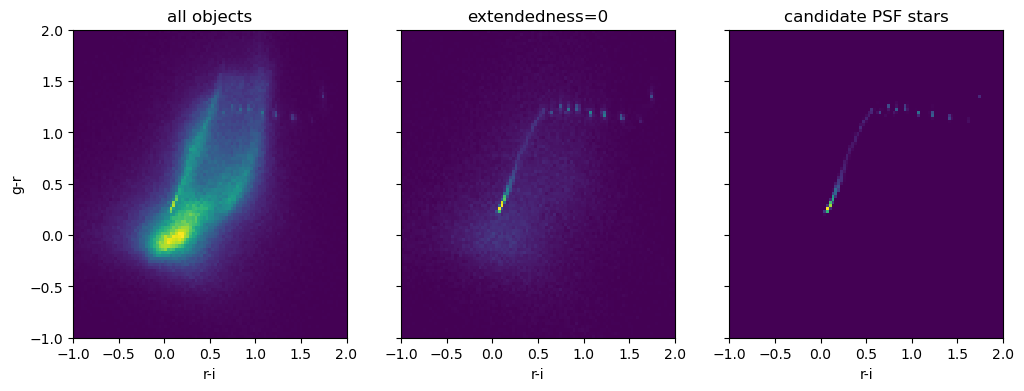

Total number of objects is: 
all objects =  883182
extendedness=0 objects =  105690
candidate PSF stars =  4086
stars used for PSF determination =  3962


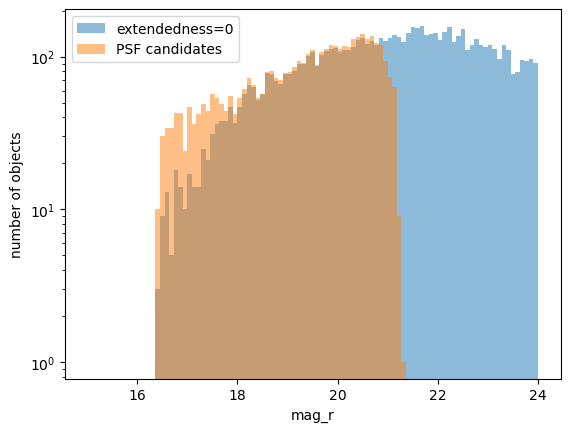

In [28]:
fig,axs = plt.subplots(1,3, figsize=(12,4), sharey=True)
axs[0].hist2d(mags["r"] - mags["i"], mags["g"] - mags["r"], bins=np.linspace(-1.0,2.0,100))
axs[0].set_title('all objects')
axs[0].set_ylabel('g-r')
axs[0].set_xlabel('r-i')
axs[1].hist2d((mags["r"] - mags["i"])[mask_stars], (mags["g"] - mags["r"])[mask_stars], bins=np.linspace(-1.0,2.0,100))
axs[1].set_title('extendedness=0')
axs[1].set_xlabel('r-i')
axs[2].hist2d((mags["r"] - mags["i"])[mask_candidates], (mags["g"] - mags["r"])[mask_candidates], bins=np.linspace(-1.0,2.0,100))
axs[2].set_title('candidate PSF stars')
axs[2].set_xlabel('r-i')
plt.show()
print("Total number of objects is: ")
print("all objects = ", len(data['coord_ra']))
print("extendedness=0 objects = ", np.sum(mask_stars))
print("candidate PSF stars = ", np.sum(mask_candidates))
print("stars used for PSF determination = ", np.sum(mask_used))

plt.figure()
plt.hist(mags["r"][mask_stars],bins=np.linspace(15,24,100),alpha=0.5,label='extendedness=0')
plt.hist(mags["r"][mask_candidates],bins=np.linspace(15,24,100),alpha=0.5,label='PSF candidates')
plt.legend()
plt.xlabel('mag_r')
plt.ylabel('number of objects')
plt.yscale('log')
plt.show()

## Results:

Finally we look at this extendedness as a function of magnitude for these candidate stars, where you can see these objects being classified as extended objects, and then do another common test of the star-galaxy separation, which is the object size.  

You can see the object size for candidate PSF stars being narrowly defined with again a large cloud of sizes being more typical of galaxies. 


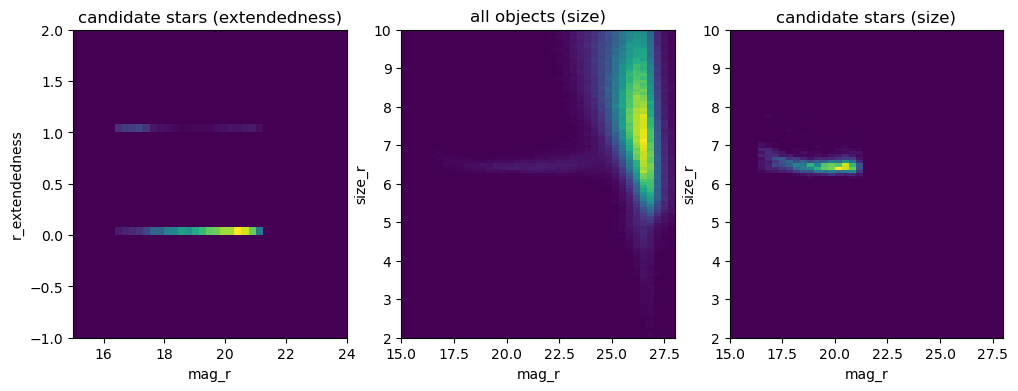

In [29]:
fig,axs = plt.subplots(1,3, figsize=(12,4), sharey=False)
axs[0].hist2d(mags["r"][mask_candidates], data['r_extendedness'][mask_candidates], bins=[np.linspace(15,24,40),np.linspace(-1,2,40)])
axs[0].set_xlabel('mag_r')
axs[0].set_ylabel('r_extendedness')
axs[0].set_title('candidate stars (extendedness)')
axs[1].hist2d(mags["r"], size["r"], bins=[np.linspace(15,28,40),np.linspace(2.0,10,100)])
axs[1].set_xlabel('mag_r')
axs[1].set_ylabel('size_r')
axs[1].set_title('all objects (size)')
axs[2].hist2d(mags["r"][mask_candidates], size["r"][mask_candidates], bins=[np.linspace(15,28,40),np.linspace(2.0,10.0,100)])
axs[2].set_title('candidate stars (size)')
axs[2].set_xlabel('mag_r')
axs[2].set_ylabel('size_r')
plt.show()



## Metrics and Updates


The science requirements document for DESC is [here](https://arxiv.org/abs/1809.01669), and the LSST one is [here](https://www.lsst.org/scientists/publications/science-requirements-document). 

From the LSST requirements document, we relate the most relevant requirements. Note that PSF metrics are in the srv_shear test, and photometric metrics are in the srv_photometry test. Depth is also defined using star catalogs, but will be detailed in a separate test. 

### DESC SRD requirements

Stellar contamination
- Detailed requirement WL5 (Y10): Systematic uncertainty in the stellar contamination of the source sample shall not exceed 0.1% in the Y10 DESC WL analysis.
- Goal WL5 (Y1): Systematic uncertainty in the stellar contamination of the source sample should not exceed 0.4% in the Y1 DESC WL analysis.

We also note that the number of standard stars observed as a metric of important to SN: 
- Our ability to calibrate the LSST photometric system for the supernovae depends on the number of standard stars used for calibration, as any systematic uncertainty related to spatial uniformity reduces as √Nstandards. Observing multiple standard stars over the field of view is therefore central to achieving our calibration goals while staying within LSST SRD requirements.


### How to improve these results

If you require a cleaner sample, you can consider a number of options 
- cross-matching to external star catalogs for bright stars
- restricting to high S/N stars
- restricting the magnitudes as is done for the PSF

Anything other star-based tests you'd like to add? Please contact the SRV working group or submit a github issue!


## Notebook updates

Things we'd like to add or update if we have the time!
- quantify stellar contamination